# Загрузка Pandas и очистка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
%matplotlib inline

In [ ]:
# Загружаем специальный удобный инструмент для разделения датасета:
# from sklearn.model_selection import train_test_split

In [ ]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
from datetime import datetime, timedelta

In [3]:
import string
import re

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [134]:
data = pd.read_csv('main_task.csv')
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# Предобработка

## Обработка NAN

У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, даже отсутствие информации может быть важным признаком!
По этому __перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак__

In [7]:
# Незаполнены признаки: Number of Reviews, Cuisine Style, Price Range, Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')
data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')

In [8]:
# формируем список городов, который нам понадобится в дальнейшем
cities_lst = list(data.City.unique())

In [9]:
# Небольшая подготовка:формируем список медиан по количеству отзывов в каждом городе
city_no_rev = data.groupby('City').agg({'Number of Reviews': 'median'})[
    'Number of Reviews'].to_dict()

In [10]:
# Заполняем число отзывов медианным по городу, там, где оно пропущено
for city in cities_lst:
    mask = (data.City == city) & data['Number of Reviews'].isna()
    data.loc[mask, 'Number of Reviews'] = city_no_rev[city]

In [11]:
# по опыту посещения европейских ресторанов делаем признак Price Range ординальным
# с правильным соотношением цен:
data['Price Range'] = data['Price Range'].map(
    {'$': 1, '$$ - $$$': 2, '$$$$': 6})

In [12]:
# выясняем средний ценовой уровень в зависимости от города
city_price = data.groupby('City').agg({'Price Range': 'mean'})[
    'Price Range'].to_dict()
# получается, что в городах рестораны всреднем имеют более высокую ценовую категорию,
# а в Португалии и Польше они подешевле.

In [13]:
# Заполняем ценовой уровень средним по городу, там, где оно пропущено
for city in cities_lst:
    mask = (data.City == city) & data['Price Range'].isna()
    data.loc[mask, 'Price Range'] = city_price[city]

In [14]:
# я не знаю, как заполнить отзывы какими-то средними по городу, поэтому заполняем пустым значением
data['Reviews'].fillna('"[[], []]"', inplace=True)

In [15]:
# Почитал по ссылкам о ресторанах, в записях о которых не заполнен признак "Cuisine Style".
# Выяснилось, что это может быть все, что угодно - кофейни, бары,
# фастфуды, недорогие столовые и буфеты самообслуживания. Поэтому решил для них сделать отдельное
# значение признака 'Random'.
data['Cuisine Style'].fillna("['Random']", inplace=True)

In [16]:
# данные готовы к обработке
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            40000 non-null  object 
 1   City                     40000 non-null  object 
 2   Cuisine Style            40000 non-null  object 
 3   Ranking                  40000 non-null  float64
 4   Rating                   40000 non-null  float64
 5   Price Range              40000 non-null  float64
 6   Number of Reviews        40000 non-null  float64
 7   Reviews                  40000 non-null  object 
 8   URL_TA                   40000 non-null  object 
 9   ID_TA                    40000 non-null  object 
 10  Number_of_Reviews_isNAN  40000 non-null  uint8  
 11  Cuisine Style_isNAN      40000 non-null  uint8  
 12  Price Range_isNAN        40000 non-null  uint8  
 13  Reviews_isNAN            40000 non-null  uint8  
dtypes: float64(4), object(

## Обработка признаков

### Cuisine Style

Разбираю строку с перечислением кухонь в список названий.

In [17]:
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda row: list(cusine[1:-1] for cusine in row[1:-1].strip().split(', ')))

Нахожу общее число стилей кухни (включая Random)

In [18]:
len(np.unique(np.hstack(data['Cuisine Style'])))

126

И список всех стилей кухни.

In [19]:
all_cuisine = list(cuisine[0] for cuisine in Counter(
    np.hstack(data['Cuisine Style'])).most_common())

### ID_TA

In [20]:
# разбираем  ID_TA
data['ID_TA'] = data['ID_TA'].apply(lambda row: row[1:]).apply(int)

In [35]:
# выясняем, что здесь происходит
data['ID_TA'].value_counts().head()

11921719    2
13002276    2
8753348     2
4600226     2
11698990    2
Name: ID_TA, dtype: int64

In [24]:
data[data['ID_TA'] == 11921719]['URL_TA']

10819    /Restaurant_Review-g187514-d11921719-Reviews-C...
12628    /Restaurant_Review-g187514-d11921719-Reviews-C...
Name: URL_TA, dtype: object

In [25]:
data['URL_TA'][10819]

'/Restaurant_Review-g187514-d11921719-Reviews-Crepets-Madrid.html'

In [26]:
data['URL_TA'][12628]

'/Restaurant_Review-g187514-d11921719-Reviews-Crepets-Madrid.html'

Кажется, что это дубликаты. На самом деле записи различаются признаками Restaurant_id и Ranking. Таких пар 20.

In [30]:
data.loc[[10819, 12628], :]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number_of_Reviews_isNAN,Cuisine Style_isNAN,Price Range_isNAN,Reviews_isNAN
10819,id_2197,Madrid,[Random],2199.0,4.5,2.024166,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,11921719,0,1,1,0
12628,id_2329,Madrid,[Random],2331.0,4.5,2.024166,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,11921719,0,1,1,0


In [36]:
# формируем список таких дубликатов
id_ta_duplicates = data['ID_TA'].value_counts().head(37).index.tolist()

In [37]:
# и присваиваем единицы только дубликатным записям
data['duplicate_ID_TA'] = data['ID_TA'].apply(
    lambda row: row in id_ta_duplicates).astype('uint8')

### URL_TA

In [38]:
# парсить базу мы не будем, поэтому используем признак URL_TA, чтобы записать туда цифровой
# идентификатор из адресной строки.
data['URL_TA'] = data['URL_TA'].apply(lambda row: row.split(
    '-')[1]).apply(lambda row: row[1:]).apply(int)

In [40]:
# видим, что только 3 ресторана из датасета имеют уникальное значение признака,
# остальные, видимо, сетевые. Буду надеяться, что модель сама обнаружит, какие
# рестораны по этому признаку одинаковы.
data['URL_TA'].value_counts().tail(4)

1080937    2
1080936    1
950782     1
3284927    1
Name: URL_TA, dtype: int64

### Country

In [42]:
# Обогащаем данные новым признаком - страной с помощью самодельного словаря:
countries = {'Amsterdam': 'Netherlands',
             'Athens': 'Greece',
             'Barcelona': 'Spain',
             'Berlin': 'Germany',
             'Bratislava': 'Slovakia',
             'Brussels': 'Belgium',
             'Budapest': 'Hungary',
             'Copenhagen': 'Denmark',
             'Dublin': 'Ireland',
             'Edinburgh': 'United Kingdom',
             'Geneva': 'Switzerland',
             'Hamburg': 'Germany',
             'Helsinki': 'Finland',
             'Krakow': 'Poland',
             'Lisbon': 'Portugal',
             'Ljubljana': 'Slovenia',
             'London': 'United Kingdom',
             'Luxembourg': 'Luxembourg',
             'Lyon': 'France',
             'Madrid': 'Spain',
             'Milan': 'Italy',
             'Munich': 'Germany',
             'Oporto': 'Portugal',
             'Oslo': 'Norway',
             'Paris': 'France',
             'Prague': 'Czechia',
             'Rome': 'Italy',
             'Stockholm': 'Sweden',
             'Vienna': 'Austria',
             'Warsaw': 'Poland',
             'Zurich': 'Switzerland'}

In [43]:
# создаем новый признак
data['Country'] = data['City'].map(countries)

### is_capital

In [44]:
# некоторые из наших городов = столицы стран, куда приезжает больше туристов и бизнесменов,
# надо их пометить с помощью списка столиц:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
            'Bratislava', 'Vienna', 'Rome', 'Madrid',
            'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
            'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
            'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']

In [45]:
# новый признак назовем is_capital
data['is_capital'] = data['City'].apply(
    lambda row: row in capitals).astype('uint8')

In [46]:
# почти три четверти ресторанов находятся в столицах.
data['is_capital'].mean()

0.7457

### Еще несколько новых признаков - 'Ranking_norm', 'population', 'population_by_rest', 'money_by_rest'

In [47]:
# не лишне будет знать население наших городов. Словарик создадим с помощью Википедии, как и список столиц
# https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits
population = {
    'London': 9304016,
    'Paris': 2140526,
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}

In [48]:
# немного поработав над данными Евростата, получаем словарь, сколько в среднем тратит в год
# житель каждой страны на рестораны:
money_for_rest_by_country = {'Belgium': 1280.0,
                             'Bulgaria': 350.0,
                             'Czechia': 840.0,
                             'Denmark': 1500.0,
                             'Germany': 1100.0,
                             'Estonia': 830.0,
                             'Ireland': 3350.0,
                             'Greece': 1425.0,
                             'Spain': 2270.0,
                             'France': 1370.0,
                             'Italy': 1820.0,
                             'Cyprus': 2940.0,
                             'Latvia': 600.0,
                             'Lithuania': 410.0,
                             'Luxembourg': 2350.0,
                             'Hungary': 630.0,
                             'Malta': 2820.0,
                             'Netherlands': 1690.0,
                             'Austria': 3080.0,
                             'Poland': 270.0,
                             'Portugal': 1800.0,
                             'Romania': 210.0,
                             'Slovenia': 930.0,
                             'Slovakia': 550.0,
                             'Finland': 1430.0,
                             'Sweden': 1420.0,
                             'United Kingdom': 2120.0,
                             'Iceland': 4710.0,
                             'Norway': 1940.0,
                             'Switzerland': 1425.0}

In [49]:
# если еще немного постараться, то можно посчитать, сколько денег тратят на рестораны в год
# все жители каждого из наших городов:
rest_market_value = dict(
    ((city), (population[city] * money_for_rest_by_country[countries[city]])) for city in cities_lst)

In [50]:
# проверка показала, что мы охватили все города
len(rest_market_value)

31

In [51]:
# для создания нескольких признаков надо еще немного потрудиться:
# создать словарь количества ресторанов по городам:
no_rests_by_city = data.groupby('City').agg(
    {'Ranking': 'count'})['Ranking'].to_dict()

In [52]:
# надеюсь, что признаки money_by_rest и population_by_rest будут полезны, а пронормированный
# по числу ресторанов Ranking_norm точно пригодится:
data['Total_no_of_rests'] = data['City'].map(no_rests_by_city)
data['Ranking_norm'] = data['Ranking'] / data['Total_no_of_rests']
data['population'] = data['City'].map(population)
data['population_by_rest'] = data['population'] / data['Total_no_of_rests']
data['rest_market_value'] = data['City'].map(rest_market_value)
data['money_by_rest'] = data['rest_market_value'] / \
    (data['Total_no_of_rests']*1000000)
data.drop(['Total_no_of_rests', 'rest_market_value'], axis=1, inplace=True)
# сохраняем population
data['population'] = data['population'] / 100000

### Признак, указывающий на уникальный стиль кухни в ресторане - 'is_rare_cousine'

In [61]:
# среди них есть очень редкие кухни.
all_cuisine[122:]

['Yunnan', 'Xinjiang', 'Burmese', 'Latvian']

In [55]:
# Для каждого города найдем список редких кухонь - в каждом городе он свой.
# Потом пометим рестораны с редкими кухнями
rare_cusines = {}
for city in cities_lst:
    cnt = Counter(data[data['City'] == city]
                  ['Cuisine Style'].values.sum()).most_common()
    rare_cusines[city] = []
    for cuisine, no in cnt:
        if no == 1:
            rare_cusines[city].append(cuisine)

In [76]:
# определим функцию, возвращающую единицу, если хоть один стиль кухни данного ресторана
# является редким для данного города


def is_rare_cousine(row):
    for cousine in row:
        if cousine in rare_cusines[city]:
            return 1
    return 0

In [77]:
# и применим эту функцию, сгруппировав рестораны по городам
for city in cities_lst:
    mask = (data.City == city)
    data.loc[mask, 'is_rare_cousine'] = data.loc[mask,
                                                 'Cuisine Style'].apply(is_rare_cousine)

### Признаки 'Restaurant_id' и 'isin_chain'

In [82]:
# Признак 'Restaurant_id' практически неотличим от признака 'Ranking'.
# Убедимся в этом, переведя его в численный вид:
data['Restaurant_id'] = (data['Restaurant_id'].map(lambda x: x[3:])).apply(int)
data[['Restaurant_id', 'Ranking']].corr()

,Restaurant_id,Ranking
Restaurant_id,1.0,1.0
Ranking,1.0,1.0


Однако для тестового датасета на Kaggle это не так, поэтому сохраним признак  'Restaurant_id'

In [83]:
# при этом у нас есть группы ресторанов с одинаковым id, видимо, они принадлежат к сетям. Надо бы их пометить
id_count = data['Restaurant_id'].value_counts()
isin_chain = list(set(id_count[id_count.values > 1].index))
len(isin_chain)

7204

In [84]:
# помечаем их
data['isin_chain'] = data['Restaurant_id'].isin(isin_chain).astype('uint8')

### Разбираем признак Reviews на даты и слова. Из дат формируем 2 новых признака, а слова отзывов ранжируем для использования как Dummy.

__Разбираем даты__

Формируем признаки 'all_dates_ISNA', 'before_date_ISNA', 'interval', 'days since last rew'

In [86]:
# Формируем вспомогательный признак List of Reviews, который в дальнейшем разберем на слова:
data['List of Reviews'] = data.Reviews.apply(
    lambda row: row[2:-2].split('], [')[0][1:-1].split("', '"))

In [87]:
# Формируем вспомогательный признак 'dates', который в дальнейшем разберем
# на 2 признака - количество дней с последнего отзыва и количество дней между отзывами:
data['dates'] = data.Reviews.apply(
    lambda row: row[2:-2].split('], [')[1][1:-1].split("', '"))

In [88]:
# Признак 'dates' содержит ни одной, одну или две даты. Если признак не заполнен,
# заполняем его списком из пустой строки ( первое, что пришло в голову ).
data['dates'] = data['dates'].apply(lambda row: [''] if row == None else row)

In [89]:
# готовим значение неопределенной даты-времени

nat = pd.NaT                               # np.datetime64('NaT')

# мы уверены, что в списке дат на первом месте или список из пустой строки или первая дата,
# если это дата, записываем ее в признак Last date

data['Last date'] = data['dates'].apply(lambda row: datetime.strptime(
    row[0], '%m/%d/%Y')if len(row[0]) > 0 else nat)

# Если длина списка в значении признака 'dates' больше 1, там есть еще одна дата.
# Записываем ее в признак 'Before date'

data['Before date'] = data['dates'].apply(lambda row: datetime.strptime(
    row[1], '%m/%d/%Y')if len(row) > 1 else nat)

In [90]:
# Как оказалось, иногда хронология дат перепутана. Я не увидел, что это связано с целевой переменной,
# поэтому просто приводим даты в порядок:
data['Last date'], data['Before date'] = data[['Last date', 'Before date']
                                              ].values.max(axis=1), data[['Last date', 'Before date']].values.min(axis=1)

In [91]:
# помечаем строки с одной или обоими неопределенными датами
data['all_dates_ISNA'] = data['Last date'].isna().astype('uint8')
data['before_date_ISNA'] = data['Before date'].isna().astype('uint8')

In [92]:
# вычисляем временной интервал между отзывами в виде целого числа дней:
data['interval'] = (data['Last date'] - data['Before date']
                    ).astype('timedelta64[D]')

In [93]:
# договариваемся для удобства, что дата самого позднего из всех отзывов - это "сегодняшний день"
# от него будем отсчитывать назад все количества дней в признаках
day_now = data['Last date'].max()

In [94]:
# вот он:
day_now

Timestamp('2018-02-26 00:00:00')

Из дат формируем 2 новых числовых признака для моделирования: количество дней со дня последнего отзыва и временной интервал между отзывами в дня

In [95]:
# количество дней со дня последнего отзыва - заполняем средним значением
data['days since last rew'] = (
    day_now - data['Last date']).astype('timedelta64[D]')
days_median = int(data['days since last rew'].median())
data['days since last rew'].fillna(days_median, inplace=True)

In [96]:
# временной интервал между отзывами в днях
data['interval'].fillna(data['interval'].median(), inplace=True)

__Разбираем отзывы на слова__

Я применил самый простой и быстрый способ разбора по причине отсутствия навыка и ограниченного времени. Я потерял зависимости целевой переменной от идиоматических выражений английского языка (состоящих из нескольких слов и обладающих самостоятельным смыслом, выделять которые надо было до разбиения на слова). Тем не менее надеюсь, что просто выделение ключевых слов даст нам возможность улучшить модель.

In [97]:
# это полезная константа, содержащая все знаки препинания.
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [98]:
# Определяем функцию, переводящую каждую строку rev (текст одного отзыва) из row
# (значения признака 'List of Reviews') в нижний регистр, заменяющую пунктуацию, разделяющую строку на слова
# и удаляющую числа


def reviews_tolist(row):
    table = str.maketrans(dict.fromkeys(string.punctuation, ' '))
    words = []
    for rev in row:
        words += rev.lower().translate(table).split(' ')
    words = [w for w in words if (not w.isdigit() & (not w == ' '))]
    return words

In [99]:
# применяем функцию
data['rew words'] = data['List of Reviews'].apply(reviews_tolist)

In [100]:
# вуаля
data['rew words'].head()

0    [good, food, at, your, doorstep, a, good, hote...
1         [unique, cuisine, delicious, nepalese, food]
2         [catch, up, with, friends, not, exceptional]
3                                                   []
4    [best, place, to, try, a, bavarian, food, nice...
Name: rew words, dtype: object

In [101]:
# выбираем и ранжируем популярные слова из списков data['rew words']
pop_words = list(word[0] for word in Counter(
    np.hstack(data['rew words'])).most_common(101))

In [102]:
# самое частое слово - пустое
pop_words[0]

''

In [103]:
# удаляем его из списка
pop_words = pop_words[1:]

Итак, мы сделали список из 100 самых частых слов, встречающихся в отзывах. 

## Создание признаков Dummy

In [104]:
# сначала делаем Dummies на каждый стиль кухни:
for cuisine in all_cuisine:
    data[cuisine] = data['Cuisine Style'].apply(
        lambda row: cuisine in row).astype('uint8')

In [105]:
# Делаем Dummy из 100 ключевых слов
for word in pop_words:
    data[word] = data['rew words'].apply(
        lambda row: word in row).astype('uint8')

In [106]:
# Делаем Dummy из всех городов
data = pd.concat([data, pd.get_dummies(data.City, drop_first=False)], axis=1)

In [107]:
# Делаем Dummy из всех стран
data = pd.concat([data, pd.get_dummies(
    data.Country, drop_first=False)], axis=1)

## Готовим данные для моделирования

In [108]:
# Копируем наш датасет, чтобы не потерять данные, которые, возможно, нам еще пригодятся
df = data.copy()

In [109]:
# Удаляем все колонки с типом данных object
object_columns = ['City', 'Cuisine Style', 'Reviews',
                  'Country', 'List of Reviews', 'dates', 'rew words']
df.drop(object_columns, axis=1, inplace=True)

In [110]:
# Удаляем все колонки с типом данных DateTime
dt_columns = ['Last date', 'Before date']
df.drop(dt_columns, axis=1, inplace=True)

In [112]:
# проверяем тип данных оставшихся колонок
# df.info(verbose=True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [113]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis=1)
y = df['Rating']

In [114]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [115]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [116]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30000, 301), (10000, 301), (30000,), (10000,))

# Создаём, обучаем и тестируем модель

In [117]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [118]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [119]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений
# от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20195199999999996


Смотрим, какие признаки были важнейшими для модели:

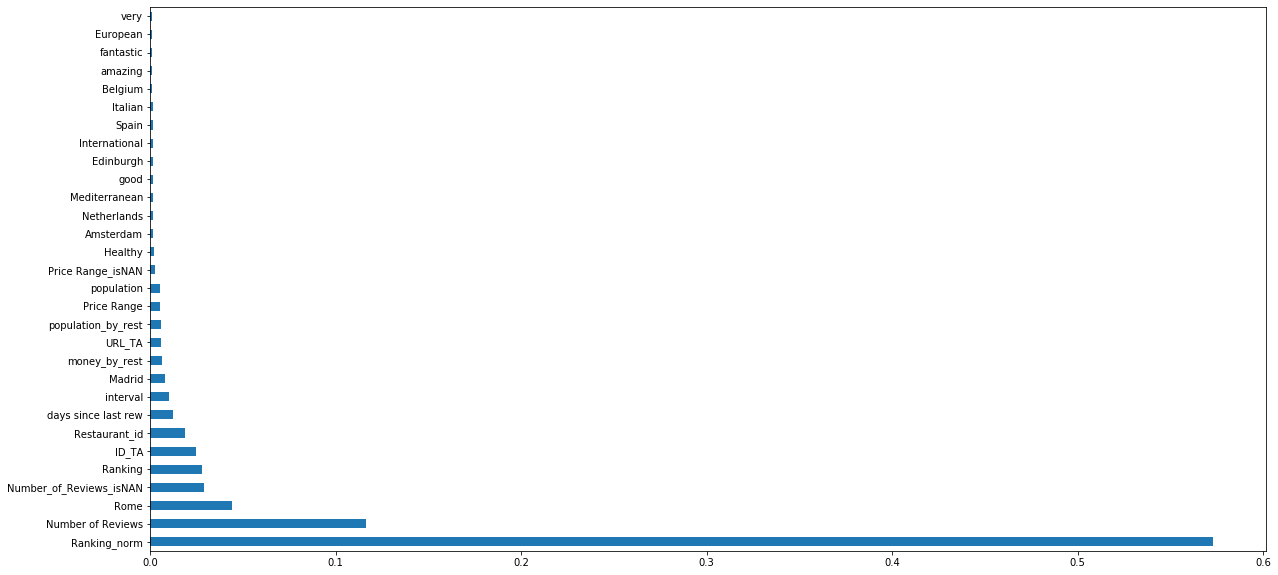

In [123]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [126]:
# составляем список важнейших
main_features = feat_importances.nlargest(30).index.tolist()

In [127]:
# Еще раз копируем датасет, оставив только важнейшие признаки:
df = data[main_features].copy()

In [129]:
# разбиваем
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [130]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [132]:
# округляем результат ( большое спасибо Александру Осинцеву)
def rating_round(x, base=0.5):
    return base * round(x/base)


def predict(ds):
    return np.array([rating_round(x) for x in regr.predict(ds)])


y_pred = predict(X_test)

In [133]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений
# от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17025


# Вывод: правильно подобранные признаки и округление результата приводят к значительному улучшению работы модели